In [1]:
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from matplotlib.colors import ListedColormap
from matplotlib.path import Path
import scipy.ndimage as nd
from skimage.segmentation import active_contour
from skimage.color import label2rgb
import skimage.morphology as morpho
from skimage.measure import regionprops, label, find_contours

from deeplate.MMdata import MMData 
import deeplate.platesegmenter as ps

/scicore/home/nimwegen/witzg/DeepPlateSegmenter/venv-deeplate/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#define data folder
folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound'
#folder = '/Volumes/MusiqueHD/20170126_lowerbound'

In [3]:
#create micromanager data object and define metadata
MMobj = MMData(folder = folder)
positions, well = MMobj.get_position_names()
well_index = np.ravel([[x for x in range(well.shape[0]) if well[x] in y] for y in positions])
z_step = MMobj.get_zstep()

In [4]:
#this shows you the order of color acqusition
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [5]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [10]:
#choose which positions should be used to create training dataset.
#Leave as chosen_pos = [] if you just want to analyze all images in the dataset.
chosen_pos=[]
#chosen_pos = ['B3-Site_2','B11-Site_0','B11-Site_1','B11-Site_2','B9-Site_1','B8-Site_1','B10-Site_2']

In [192]:
#where should training data be saved
path_to_save = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_subsetrot/'
#path_to_save = '/Users/guillaume/Desktop/PostdocBasel/PlateSegmenter_Python_Git/DeepPlate/Learn201710126/'

#total number of positions to look at
totpos = 20

In [7]:
#collect segmentation matrices
all_correlations = np.empty((MMobj.height,MMobj.width,totpos))
all_masks = np.empty((MMobj.height,MMobj.width,totpos))
all_weights = np.empty((MMobj.height,MMobj.width,totpos))

In [14]:
#Generate training/test dataset. Loads images sequentially, segments cells based on fluorescnce,
#saves a croped image around each cell as single training example. As long as the desired number of 
#training/test dataset is not reached, new images are loaded and analyzed.
counter = 0
poscount = 0
unfinished = False
disk = morpho.disk(radius=4)
if len(chosen_pos)==0:
    chosen_pos = positions
    
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
if not os.path.exists(path_to_save+'segplot'):
    os.makedirs(path_to_save+'segplot')
    
while poscount<20:
    
    print('This is image #'+str(poscount)+': '+chosen_pos[poscount])
    
    #define current position to analyze
    position = np.argwhere(np.array(positions)==chosen_pos[poscount])[0][0]
    
    #load fluorescence image and gaussian filter it
    imfluo = MMobj.get_stack(frame=0,channel=fluo_ch,position=position, compress = 1)[:,:,0]
    imfluo_gauss = nd.gaussian_filter(imfluo,3)
    
    #calculate image gradient. Any pixel with significant gradient is used to calculate an average cell fluorecence
    imgrad = np.gradient(imfluo_gauss)
    imgrad = np.sqrt(imgrad[0]**2+imgrad[1]**2)
    mean_fluo = np.mean(imfluo[imgrad>100])

    #load bf stack and calculated correlation image
    stack = MMobj.get_stack(frame=0,channel=bf_ch,position=position, compress = 1)    
    correlated_norm = ps.phase_corr_simple(stack,thickness=800,z_step=z_step)
    correlated_norm_gauss = nd.gaussian_filter(correlated_norm,3)
    
    #filter fluo image with cross-correlation steerable filters. 
    #This enhances both cell interior regions (negative) and regions where cells touch (positive)
    steer_all = np.zeros((imfluo.shape[0],imfluo.shape[1], 20))
    for i in range(20):
        steer_all[:,:,i] = ps.steerable2_crosscorr(imfluo_gauss, i*np.pi/20,1.5)
    fluo_steer = np.max(steer_all, axis = 2)
    
    #make maks for negative regions (cells). Exclude low intensity regions which are not cells
    fluo_steer_mask = np.zeros(fluo_steer.shape)
    fluo_steer_mask[fluo_steer<0] = 1
    fluo_steer_mask[imfluo_gauss<0.8*mean_fluo]=0
    fluo_mask_lab = label(fluo_steer_mask)

    #Analyze each mask region and keep reasonably shaped ones
    cell_info = regionprops(fluo_mask_lab)
    cell_info = [x for x in cell_info if (x.area>100)&(x.solidity>0.75)]
    newMask = np.zeros(fluo_mask_lab.shape)
    for i in range(len(cell_info)):
        newMask[fluo_mask_lab == cell_info[i].label]=1
    newMask_lab = label(newMask)
    
    cell_info = regionprops(newMask_lab)
    img_all = np.pad(fluo_steer,20,mode = 'constant')
    masktot = np.zeros(img_all.shape)
    for cellid in range(len(cell_info)):

        #cell mask clean-up and definition of cell contour
        imlab_temp = np.pad(cell_info[cellid].image,3,mode = 'constant',constant_values=0)
        imlab_temp = morpho.binary_closing(imlab_temp,selem=disk)
        #imlab_temp = np.pad(imlab_temp,3,mode = 'constant',constant_values=0)

        contours = find_contours(imlab_temp,0.5)
        init = contours[0]+17*np.ones(contours[0].shape)
        init = np.fliplr(init)
        init = np.concatenate([[init[x,:],(init[x,:]+init[x+1,:])/2] for x in range(init.shape[0]-1)])

        #image cropping and active contour smoothing
        img = img_all[cell_info[cellid].bbox[0]+20-20:cell_info[cellid].bbox[2]+20+20,
         cell_info[cellid].bbox[1]+20-20:cell_info[cellid].bbox[3]+20+20]

        snake = active_contour(img, init,alpha=0.01, beta=1.0, w_line=0, w_edge=1, gamma=0.1)

        #find pixels within boundary of new contour and create mask
        cg = np.mean(snake,axis = 0)
        snake = snake-np.repeat(np.array([cg]),snake.shape[0],axis =0)
        snake = 1*snake
        snake = snake+np.repeat(np.array([cg]),snake.shape[0],axis =0)

        x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0])) # make a canvas with coordinates
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x,y)).T 

        p = Path(snake) # make a polygon
        grid = p.contains_points(points)
        mask = grid.reshape(img.shape[0],img.shape[1])

        masktot[cell_info[cellid].bbox[0]+20-20:cell_info[cellid].bbox[2]+20+20,
         cell_info[cellid].bbox[1]+20-20:cell_info[cellid].bbox[3]+20+20] = masktot[cell_info[cellid].bbox[0]+20-20:cell_info[cellid].bbox[2]+20+20,
         cell_info[cellid].bbox[1]+20-20:cell_info[cellid].bbox[3]+20+20]+mask

    #create a mask for the cell boundary. This mask is used to define the weight-image that helps the 
    #deep learning network to learn those important regions
    masktot[masktot>0] = 1
    distance = nd.distance_transform_edt(masktot)
    distance[distance != 1] = 0
    distance = morpho.binary_dilation(distance)
    distance[masktot==1] = 0
    distance = distance*10+1

    distance = distance[20:-20,20:-20]
    masktot = masktot[20:-20,20:-20]

    plt.clf()
    
    #show segmentation result
    fig, ax = plt.subplots(figsize=(20,20))
    plt.imshow(1-correlated_norm,cmap='gray')
    #plt.imshow(label(masktot),alpha = 0.5, cmap = ListedColormap ( np.random.rand ( 256,3)))
    plt.imshow(label2rgb(label(masktot),bg_label=0),alpha = 0.5)
    plt.show()
    fig.savefig(path_to_save+'segplot/'+positions[poscount]+'.png')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    all_correlations[:,:,poscount] = correlated_norm_gauss
    all_masks[:,:,poscount] = masktot
    all_weights[:,:,poscount] = distance
    
    poscount+=1
    
    

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [15]:
if not os.path.exists(path_to_save+'raw'):
    os.makedirs(path_to_save+'raw')
np.save(path_to_save+'raw/'+'correlations.npy', all_correlations)
np.save(path_to_save+'raw/'+'masks.npy', all_masks)
np.save(path_to_save+'raw/'+'weights.npy', all_weights)


In [ ]:
grid_size = all_correlations.shape[0]
grid_x = np.tile(np.arange(grid_size), grid_size)
grid_y = np.repeat(np.arange(grid_size), grid_size)

<IPython.core.display.Javascript object>


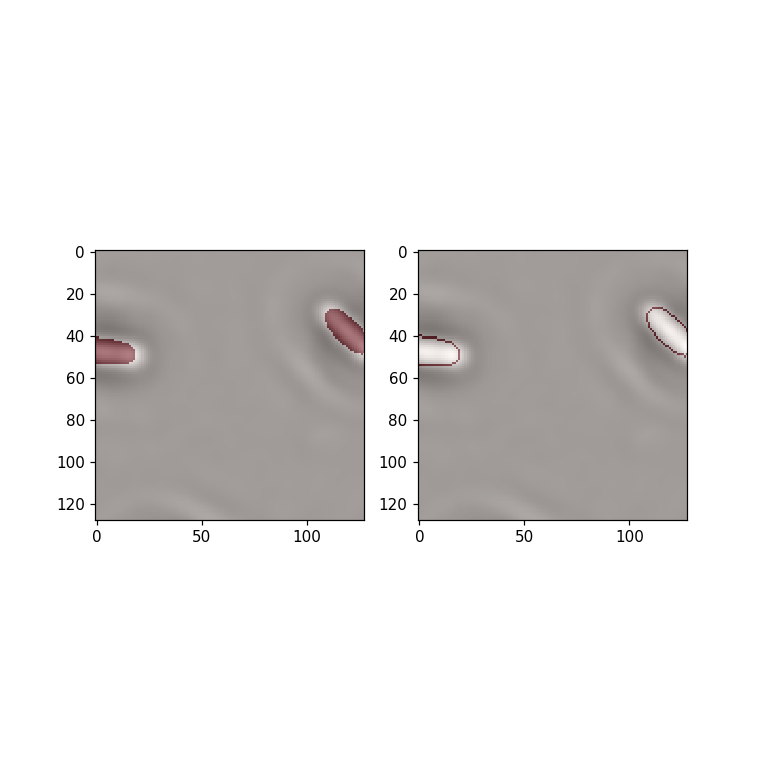

IndexError: index 20 is out of bounds for axis 2 with size 20

In [54]:
%matplotlib notebook
im_ind=20
fig, ax = plt.subplots(figsize=(7,7))
image = all_masks[:,:,im_ind].copy()
ax.imshow(all_correlations[:,:,im_ind],cmap='gray')
imax = ax.imshow(image,alpha = 0.5,cmap = 'Reds')

pts = ax.scatter(grid_x, grid_y,alpha =0)

selector = SelectFromCollection(ax, imax, pts, image)

In [48]:
#enforce changes
all_masks[:,:,im_ind] = selector.image

In [55]:
images_to_suppress = [6,11,15,16,17,18,19]

In [71]:
tokeep = list(set(np.arange(20)) -set(images_to_suppress))

In [72]:
newall_correlations = np.empty((all_masks.shape[0],all_masks.shape[1],len(tokeep)))
newall_masks = np.empty((all_masks.shape[0],all_masks.shape[1],len(tokeep)))
newall_weights = np.empty((all_masks.shape[0],all_masks.shape[1],len(tokeep)))

In [73]:
for i in range(len(tokeep)):
    newall_correlations[:,:,i] = all_correlations[:,:,tokeep[i]]
    newall_masks[:,:,i] = all_masks[:,:,tokeep[i]]
    newall_weights[:,:,i] = all_weights[:,:,tokeep[i]]

In [74]:
if not os.path.exists(path_to_save+'clean'):
    os.makedirs(path_to_save+'clean')
np.save(path_to_save+'clean/'+'correlations.npy', newall_correlations)
np.save(path_to_save+'clean/'+'masks.npy', newall_masks)
np.save(path_to_save+'clean/'+'weights.npy', newall_weights)


In [75]:
#load cleaned data
correlations = np.load(path_to_save+'clean/'+'correlations.npy')
masks = np.load(path_to_save+'clean/'+'masks.npy')
weights = np.load(path_to_save+'clean/'+'weights.npy')

In [87]:
numsplits = int(correlations.shape[0]/128)
numimages = correlations.shape[2]

In [88]:
#Definition of structures containing training and test datasets
#Dimensions and size of training and test datasets
channels = 1
image_rows = 128
image_cols = 128
num_train = numsplits**2*numimages-20
num_test = 20

num_tot = num_train+num_test
imgs = np.ndarray((num_train, image_rows, image_cols,channels), dtype=np.float64)
imgs_mask = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_weight = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_test = np.ndarray((num_test, image_rows, image_cols,channels), dtype=np.float64)
imgs_id = np.ndarray((num_test, ), dtype=np.int32)

In [89]:
listpos = []
for k in range(numimages):
    for i in range(numsplits):
        for j in range(numsplits):
            listpos.append([i,j,k])

In [92]:
shuffle = np.random.choice(len(listpos), len(listpos), replace=False)

In [143]:
np.sum(masks)/(masks.shape[0]*masks.shape[1]*masks.shape[2])*100

5.703931588392992

In [146]:
weights[weights==11] = 200
weights[masks==1] = 20

In [194]:
num_train = 2*num_train

In [178]:
imgs = np.ndarray((num_train, image_rows, image_cols,channels), dtype=np.float64)
imgs_mask = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_weight = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_test = np.ndarray((num_test, image_rows, image_cols,channels), dtype=np.float64)
imgs_id = np.ndarray((num_test, ), dtype=np.int32)

In [179]:
for counter in range(len(listpos)):
    i=listpos[shuffle[counter]][0]
    j=listpos[shuffle[counter]][1]
    k=listpos[shuffle[counter]][2]
    
    img = correlations[i*128:(i+1)*128,j*128:(j+1)*128,k]
    randint = np.random.rand() 
    #if np.random.rand()<0.5: randint = 1000*randint
    randint = 100*randint
    img = img*randint
    img_mask = 255*masks[i*128:(i+1)*128,j*128:(j+1)*128,k]
    img_weight = weights[i*128:(i+1)*128,j*128:(j+1)*128,k]
            
    if counter<num_train:
        if channels==1:
            imgs[2*counter] = img[..., np.newaxis]
            img = img.T
            imgs[2*counter+1] = img[..., np.newaxis]
        else:
            imgs[2*counter] = img
            img = img.T
            imgs[2*counter+1] = img
        imgs_mask[2*counter] = img_mask
        img_mask = img_mask.T
        imgs_mask[2*counter+1] = img_mask
        imgs_weight[2*counter] = img_weight
        img_weight = img_weight.T
        imgs_weight[2*counter+1] = img_weight
    else:
        if channels==1:
            imgs_test[counter-num_train] = img[..., np.newaxis]
        else:
            imgs_test[counter-num_train] = img

        imgs_id[counter-num_train] = counter-num_train

In [195]:
#save all the data structures
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
np.save(path_to_save+'imgs_train.npy', imgs)
np.save(path_to_save+'imgs_mask_train.npy', imgs_mask.reshape((num_train,image_cols*image_rows)))
np.save(path_to_save+'imgs_weight_train.npy', imgs_weight.reshape((num_train,image_cols*image_rows)))
np.save(path_to_save+'imgs_test.npy', imgs_test)
np.save(path_to_save+'imgs_id_test.npy', imgs_id)

In [130]:
%matplotlib inline

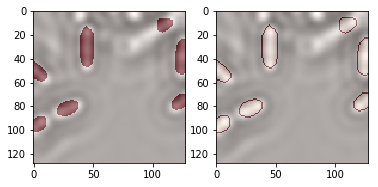

In [191]:
#check individul examples of training set
plt.subplot(1,2,1)
id = 221
plt.imshow(imgs[id,:,:,0],cmap = 'gray')
plt.imshow(np.reshape(imgs_mask[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.subplot(1,2,2)
plt.imshow(imgs[id,:,:,0],cmap = 'gray')
plt.imshow(np.reshape(imgs_weight[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.show()

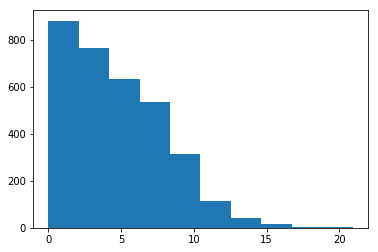

In [177]:
plt.hist([imgs[x,:,:,0].max() for x in range(imgs.shape[0])])
plt.show()

In [20]:
import numpy as np

from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path


class SelectFromCollection(object):
    

    def __init__(self, ax, imax, collection, image, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.image = image
        self.imax = imax

        self.xys = collection.get_offsets()
        self.poly = PolygonSelector(ax, self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        
        self.image[np.unravel_index(self.ind,(self.image.shape[0],self.image.shape[1]))]=0
        self.imax.set_array(self.image)
        self.canvas.draw_idle()

    def disconnect(self):
        self.poly.disconnect_events()
        self.canvas.draw_idle()